In [1]:
from utlities.cal_utils import Format, Analyze 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

import seaborn as sns
import math
import scipy
from scipy.signal import find_peaks
import numpy as np
import os

rep = "2"

path_data = f"./Data/rep{rep}_data.xlsx"
path_md = f"./Data/rep{rep}_md.xlsx"


folder = f"./picker_outputs_rep{rep}"

option_graphs_folder_for_11mm = f"rep{rep}_11mM_option_graphs"
complete_graphs = f"rep{rep}_11mM_complete__graphs"

form = Format(path = path_data)
analyze = Analyze()

sns.set_style("darkgrid")
sns.color_palette('colorblind')


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [2]:
if not os.path.exists(folder): 
      
    # if the demo_folder directory is not present  
    # then create it. 
    os.makedirs(folder) 

In [3]:
"""This cell makes the original data for this rep tidy,  calculated the normalized AU, and saves it to an exterior excel file"""

if not os.path.exists(f'{folder}/Rep{rep}_df.csv'):

    df = form.tidy_file(delta = False, average = True, baseline = 15)
    df.to_csv(f'{folder}/Rep{rep}_df.csv', index=False)
    

In [4]:
#load the tidy excel file made in the previous cell
df = pd.read_csv(f'{folder}/Rep{rep}_df.csv')


#load in the start times for different stimulus
md = pd.read_excel(path_md)


If there are multiple average lines on one plot and another plot is missing, it is becasue the missing plot is mislabeled on the spreadsheet as a different plot name

In [5]:
if not os.path.exists(f'{folder}/{option_graphs_folder_for_11mm}'): 
      
    # if the demo_folder directory is not present then create it
                      
    os.makedirs(f'{folder}/{option_graphs_folder_for_11mm}')

In [6]:
from math import log10, floor
def round_sig(x, sig=1, small_value=1.0e-9):
    rounded = round(x, sig - int(floor(log10(max(abs(x), abs(small_value))))) - 1)

    return rounded

In [7]:
def params_for_iirfilter(mode):
        """
        Function that takes in a general level of smoothing
        and gives aproprate parameters that can be used in 
        scipy.signal.iirfilter to acheive that.

        Param: 
            mode-> String description of the general level of smoothing. 
                Options are "smooth", "medium", and "detailed"
            
        Return: The order and cut-ff_freq params for the  scipy.signal.iirfilter function
        """

       #note: primarily adjust cutoff_freq to adjust smoothing
        if mode == "detailed":
            # Designing a Butterworth IIR filter for smoothing
            order = 3  # Filter order
            cutoff_freq = 0.3 
            # Using a Butterworth low-pass filter
        
        elif mode == "medium":
            # Designing a Butterworth IIR filter for smoothing
            order = 3  # Filter order
            cutoff_freq = 0.2
            # Using a Butterworth low-pass filter

        elif mode == "smooth":
            #smoothest reasonable settings:
            order = 4  # Filter order
            cutoff_freq = 0.02
        
        else:
            print("""Error: No appropriate imput give for the params_for_iirfilter function. 
                   Try "smooth", "medium", and "detailed" instead.""")
            return
        
        return order, cutoff_freq


In [8]:
# Sets the style of the seaborn plots to 'whitegrid' with dashed grid line style
sns.set_style("whitegrid", {'grid.linestyle': '--'})

#defines parameters to be used in smoothing function
order, cutoff_freq = params_for_iirfilter("smooth")
# Apply a Butterworth filter to the data for smoothing
b, a = scipy.signal.iirfilter(N=order, Wn=cutoff_freq, btype='low', ftype='butter')

# Extracts the unique treatment types from the 'Treatment' column in the dataframe 'df'
treatments = df.Treatment.unique()

#initializes a list that stores a data frame for each cells. 
#Each mini dataframe will represent one line of the excel file with end point suggestions for the 11mM 1st phase
dfs = []

# Iterate over each unique treatment, using its index and value
for n, treat in enumerate(treatments):

    # Filter the main DataFrame of time series data to get data for the cells in the currect treatment
    temp_df = df[df["Treatment"] == treat]
    # Filter the metadata DataFrame of stimuols time to get data for the current treatment
    temp_md = md[md["Treatment"] == treat]

    #find the name of cells in the current treatment
    cells = temp_df["Cell #"].unique()

    #re-iniitialize the color pallet with each new set of plots. One color per cell
    palette = sns.color_palette("colorblind", len(cells))

   # Initialize a figure with custom dimensions, adjusted based on the number of cells
    plt.figure(figsize=(15, int(10*len(cells))))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle(f"Rep {rep}: {treat}", fontsize=15, y=0.9)

    # Iterate over each cell in the current treatment
    for m, cell in enumerate(cells):
        
        # Determine the start and end times for the stimulus from the metadata
        wind_start = temp_md["11 mM Stimulus"].iloc[0]
        wind_end = temp_md["20 mM Stimulus"].iloc[0]

        # Filter the DataFrame for the current cell and time window from the 11 mM stimulus to the next stimulus time
        plot_df = temp_df[temp_df["Cell #"] == cell]
        plot_df = plot_df[plot_df["Time (sec)"].between(wind_start, wind_end)]

        
        # Create a subplot for the current cell with a single column
        col_num = 1
        ax = plt.subplot(int(math.ceil(len(cells)/col_num)), col_num, m + 1)
        #include x and y labels on the subplot
        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("A.U.")

        # Set more frequent ticks on the x-axis
        au_change = plot_df["Normalized A.U."].max() - plot_df["Normalized A.U."].min()
        time_change = plot_df["Time (sec)"].max() - plot_df["Time (sec)"].min()
    

        # Applying the filter to the current Cell's data
        smoothed_AU = scipy.signal.filtfilt(b, a, plot_df["Normalized A.U."])
        #at the smoothed time series data to the mini data frame made for the current cell
        plot_df.insert(2, "Smoothed Normalized A.U.", smoothed_AU ,True)
      
        #plot both the smoothed and original time series data
        sns.lineplot(data = plot_df,x = "Time (sec)", y = "Normalized A.U.", color=palette[m], alpha = 0.6)
        sns.lineplot(data = plot_df,x = "Time (sec)", y = "Smoothed Normalized A.U.", color=palette[m], alpha = 1)

      
        # plot x axis ticks with a spacing of 100
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))  # Adjust the locator value as needed

        # plot y axis ticks so that there are 20 ticks on the y axis
        yspacing = round_sig((plot_df["Normalized A.U."].max()/20))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(yspacing)) 

        #label all of the graph ticks
        ax.tick_params(axis='x', labelsize=10)  # Adjust the font size of x-axis tick labels
        ax.tick_params(axis='y', labelsize=10)  # Adjust the font size of x-axis tick labels

        #detect loctaions peaks in the smoothed data
        max_locations = find_peaks(plot_df["Smoothed Normalized A.U."], distance=10, height = 3, prominence=0.1)[0][:3]

        #detect locations of vallies of the smoothed data by finding the peak of an inverted version of the graph
        inverted_signal = -plot_df["Smoothed Normalized A.U."].values
        min_locations = find_peaks(inverted_signal, distance=5, prominence=0.08)[0]
        

        #loop through all of the local minimum vally locations, find the time and absorbance they occur at 
        for location in min_locations:
            
            time = plot_df.iloc[location]["Time (sec)"]
            au = plot_df.iloc[location]["Smoothed Normalized A.U."]

            #graph the bottom of each vally as a green dot on the smoothed graph
            ax.plot(time, au, marker="o", color="green", markersize=3)

        #initialize an empty list of guesses for the end of the 1st phase of the 11 mM peak
        ends = []

        #loop through all of the local peak locations, find the time and absorbance they occur at 
        for location in max_locations:
        
            time = plot_df.iloc[location]["Time (sec)"]
            au = plot_df.iloc[location]["Smoothed Normalized A.U."]
           
           #graph the top of each peak as a red dot on the smoothed graph
            ax.plot(time, au, marker="o", color="red", markersize=3)

            """this is where the guesses are made for the end of the 11 mM 1st phase. 
            Each location is an index in the time series data.For each peak we are 
            looking through all of the minimum values that happen at a later index, 
            and therefore a later timepoint. 
            We are doing this to find the next vally that comes after the peak we plotted as we break after one loop."""
            for l in min_locations:
                if l > location:
                    time = plot_df.iloc[l]["Time (sec)"]
                    au = plot_df.iloc[l]["Smoothed Normalized A.U."]

                    
                    ends.append((time, au))
                    ax.axvline(x=time, color='grey')
                    break
                
                    
        
        cell_md_cop = temp_md.copy()

        if len(ends) == 0:

            if len(min_locations) > 0:
                time1 = plot_df.iloc[min_locations[0]]["Time (sec)"]
                ax.axvline(x=time, color='grey')
            
            else:
                time1 = np.nan
    
            if len(min_locations) > 1:
                time2 = plot_df.iloc[min_locations[1]]["Time (sec)"]
                ax.axvline(x=time2, color='grey')
            
            else:
                time2 = np.nan
            
            if len(min_locations) > 2:
                time2 = plot_df.iloc[min_locations[2]]["Time (sec)"]
                ax.axvline(x=time3, color='grey')
            
            else:
                time3 = np.nan

            cell_md_cop["End Option 1"] = time1
            cell_md_cop["End Option 2"] = time2
            cell_md_cop["End Option 3"] = time3

        
        elif len(ends) == 1:

            cell_md_cop["End Option 1"] = int(ends[0][0])
            cell_md_cop["End Option 2"] = np.nan
            cell_md_cop["End Option 3"] = np.nan


            if len(min_locations) > 1:
                time2 = plot_df.iloc[min_locations[1]]["Time (sec)"]
                ax.axvline(x=time2, color='grey')
                cell_md_cop["End Option 2"] = time2

            if len(min_locations) > 2:
                time3 = plot_df.iloc[min_locations[2]]["Time (sec)"]
                ax.axvline(x=time3, color='grey')
                cell_md_cop["End Option 3"] = time3
        #new_md.at[row_ind, '11 mM End'] = end[0]
            
        elif len(ends) == 2:
            cell_md_cop["End Option 1"] = int(ends[0][0])
            cell_md_cop["End Option 2"] = int(ends[1][0])
            cell_md_cop["End Option 3"] = np.nan

            if len(min_locations) > 2:
                time3 = plot_df.iloc[min_locations[2]]["Time (sec)"]
                ax.axvline(x=time3, color='grey')
                cell_md_cop["End Option 3"] = time3
                
        elif len(ends) > 2:
            cell_md_cop["End Option 1"] = int(ends[0][0])
            cell_md_cop["End Option 2"] = int(ends[1][0])
            cell_md_cop["End Option 3"] = int(ends[2][0])

        cell_md_cop["Represent"] = "TRUE"



        dfs.append(cell_md_cop)

        # Enable and enlarge minor ticks for visibility
        ax.minorticks_on()
        # Add minor ticks on the x-axis
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adds 1 minor tick between major ticks
        ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=5)

        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adds 1 minor tick between major ticks
        #ax.tick_params(axis='y', which='minor', bottom=True, top=False, length=5)


        ax.set_xlabel("Time (sec)", fontsize=12)
        ax.set_ylabel("A.U.", fontsize=12)
        # chart formatting
        ax.set_title(f"{treat.upper()} \n {cell}")
        
        

    plt.savefig(f"{folder}/{option_graphs_folder_for_11mm}/Rep{rep}_{treat}_graphs.png", bbox_inches = "tight");
    plt.close()
new_md = pd.concat(dfs)
new_md["Quality"] = ""
new_md["11 mM End"] = ""
new_md["Notes"] = ""



    
new_md.to_excel(f"{folder}/options_rep{rep}.xlsx")


In [9]:

new_md

,Treatment,11 mM Stimulus,20 mM Stimulus,KCL Stimulus,11 mM End,End Option 1,End Option 2,End Option 3,Represent,Quality,Notes
0,NoRTG NoInh - Islet 1,480,1740,2700,,1159.00,1521.000,NaN,TRUE,,
0,NoRTG NoInh - Islet 1,480,1740,2700,,1095.00,1517.000,NaN,TRUE,,
0,NoRTG NoInh - Islet 1,480,1740,2700,,1379.00,1516.445,NaN,TRUE,,
0,NoRTG NoInh - Islet 1,480,1740,2700,,1370.00,1522.000,NaN,TRUE,,
0,NoRTG NoInh - Islet 1,480,1740,2700,,1361.00,1517.000,NaN,TRUE,,
...,...,...,...,...,...,...,...,...,...,...,...
15,10wt% RTG Inh - Islet 3,1200,1980,3060,,1476.00,1756.000,1756.02,TRUE,,
15,10wt% RTG Inh - Islet 3,1200,1980,3060,,NaN,NaN,NaN,TRUE,,
15,10wt% RTG Inh - Islet 3,1200,1980,3060,,1569.54,1810.410,NaN,TRUE,,
15,10wt% RTG Inh - Islet 3,1200,1980,3060,,1502.00,1832.000,NaN,TRUE,,


In [10]:
if not os.path.exists(f'{folder}/{complete_graphs}'): 
      
    # if the demo_folder directory is not present then create it
                      
    os.makedirs(f'{folder}/{complete_graphs}')

In [11]:
treatments = df.Treatment.unique()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# loop through the length of tickers and keep track of index
for n, treat in enumerate(treatments):

    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    cells = temp_df["Cell #"].unique()

    #re-iniitialize the color pallet with each new set of plots:
    palette = sns.color_palette("colorblind", len(cells))

    #initialize plot
    plt.figure(figsize=(15, int(10*len(cells))))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle(f"Rep {rep}: {treat}", fontsize=15, y=0.887)

    for m, cell in enumerate(cells):

        plot_df = temp_df[temp_df["Cell #"] == cell]

        col_num = 1
        ax = plt.subplot(int(math.ceil(len(cells)/col_num)), col_num, m + 1)


        #if there is no metadata
        if len(temp_md) == 0:
            print(f"There is no metadata on {treat} so no starts or ends of curves are unknown")
            continue

        #if we have metadata on the cell
        else:
            # filter df and plot ticker on the new subplot axis
            ax.axvline(x=temp_md["11 mM Stimulus"].iloc[0], color='grey')
            ax.axvline(x=temp_md["20 mM Stimulus"].iloc[0], color='grey')

            # Text labels
            y_pos = ax.get_ylim()[0]  # Position at the bottom of the graph
            ax.text(temp_md["11 mM Stimulus"].iloc[0], y_pos, "11mM Start", color='grey', verticalalignment='bottom')
            ax.text(temp_md["20 mM Stimulus"].iloc[0], y_pos, "20mM Start", color='grey', verticalalignment='bottom')

            ax.set_xlabel("Time (sec)")
            ax.set_ylabel("A.U.")
            #ax.legend()
            #ax.get_legend().remove()
            #ax.set_xlabel("")

            sns.lineplot(data = plot_df,x = "Time (sec)", y = "Normalized A.U.", color=palette[m])
            # Set more frequent ticks on the x-axis

            xspacing = int(round_sig((plot_df["Time (sec)"].max() - plot_df["Time (sec)"].min())/20))
            ax.xaxis.set_major_locator(ticker.MultipleLocator(xspacing))  # Adjust the locator value as needed
            yspacing = round_sig((plot_df["Normalized A.U."].max()/10))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(yspacing)) 
            ax.tick_params(axis='x', labelsize=10)  # Adjust the font size of x-axis tick labels
            ax.tick_params(axis='y', labelsize=10)  # Adjust the font size of x-axis tick labels

            # Enable and enlarge minor ticks for visibility
            ax.minorticks_on()
            # Add minor ticks on the x-axis
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adds 1 minor tick between major ticks
            ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=5)


            ax.set_xlabel("Time (sec)", fontsize=12)
            ax.set_ylabel("A.U.", fontsize=12)
            # chart formatting
            ax.set_title(f"{treat.upper()} \n {cell}")

    plt.savefig(f"{folder}/{complete_graphs}/rep{rep}_{treat}_graphs.png", bbox_inches = "tight")
    plt.close();


In [12]:
md = analyze.AUC(md, df, style="rect")
md = analyze.AUC(md, df, style="trap")

In [13]:
md["Duty"] = (md["11 mM Stimulus"] - md["11 mM End"])/(md["11 mM End"] - md["20 mM Stimulus"])

In [14]:
df[df["Treatment"] == treat]

,Time (sec),[hr]:[min]:[sec],A.U.,Normalized A.U.,Cell #,Treatment
1093246,1.295,00:00:01.295000,2.250000,0.933998,Cell 1,10wt% RTG Inh - Islet 3
1093247,2.590,00:00:02.590000,2.250000,0.933998,Cell 1,10wt% RTG Inh - Islet 3
1093248,3.885,00:00:04,2.250000,0.933998,Cell 1,10wt% RTG Inh - Islet 3
1093249,5.180,00:00:05.180000,2.000000,0.830220,Cell 1,10wt% RTG Inh - Islet 3
1093250,6.475,00:00:06.475000,2.500000,1.037775,Cell 1,10wt% RTG Inh - Islet 3
...,...,...,...,...,...,...
1141216,3264.695,00:54:24.695000,15.942824,4.090001,AVG,10wt% RTG Inh - Islet 3
1141217,3265.990,00:54:25.990000,16.354588,4.195636,AVG,10wt% RTG Inh - Islet 3
1141218,3267.285,00:54:27.285000,16.248529,4.168427,AVG,10wt% RTG Inh - Islet 3
1141219,3268.580,00:54:28.580000,16.050765,4.117692,AVG,10wt% RTG Inh - Islet 3


In [15]:
md_plot = md.copy()

md_plot["Treatment"] = md_plot["Treatment"].str.split("-", n = 1, expand = True)[0]




In [16]:
md_plot.to_excel(f"{folder}/Rep{rep}_11mM_curve_raw_calculations.xlsx")

Area under the curve was calculated by normalizing the data, subtracting the values of the curve by the starting value, and then using a trapazoid AUC but could easily to rectangular. The error bars depicted are a 95 percent confidence interval but I can change this.

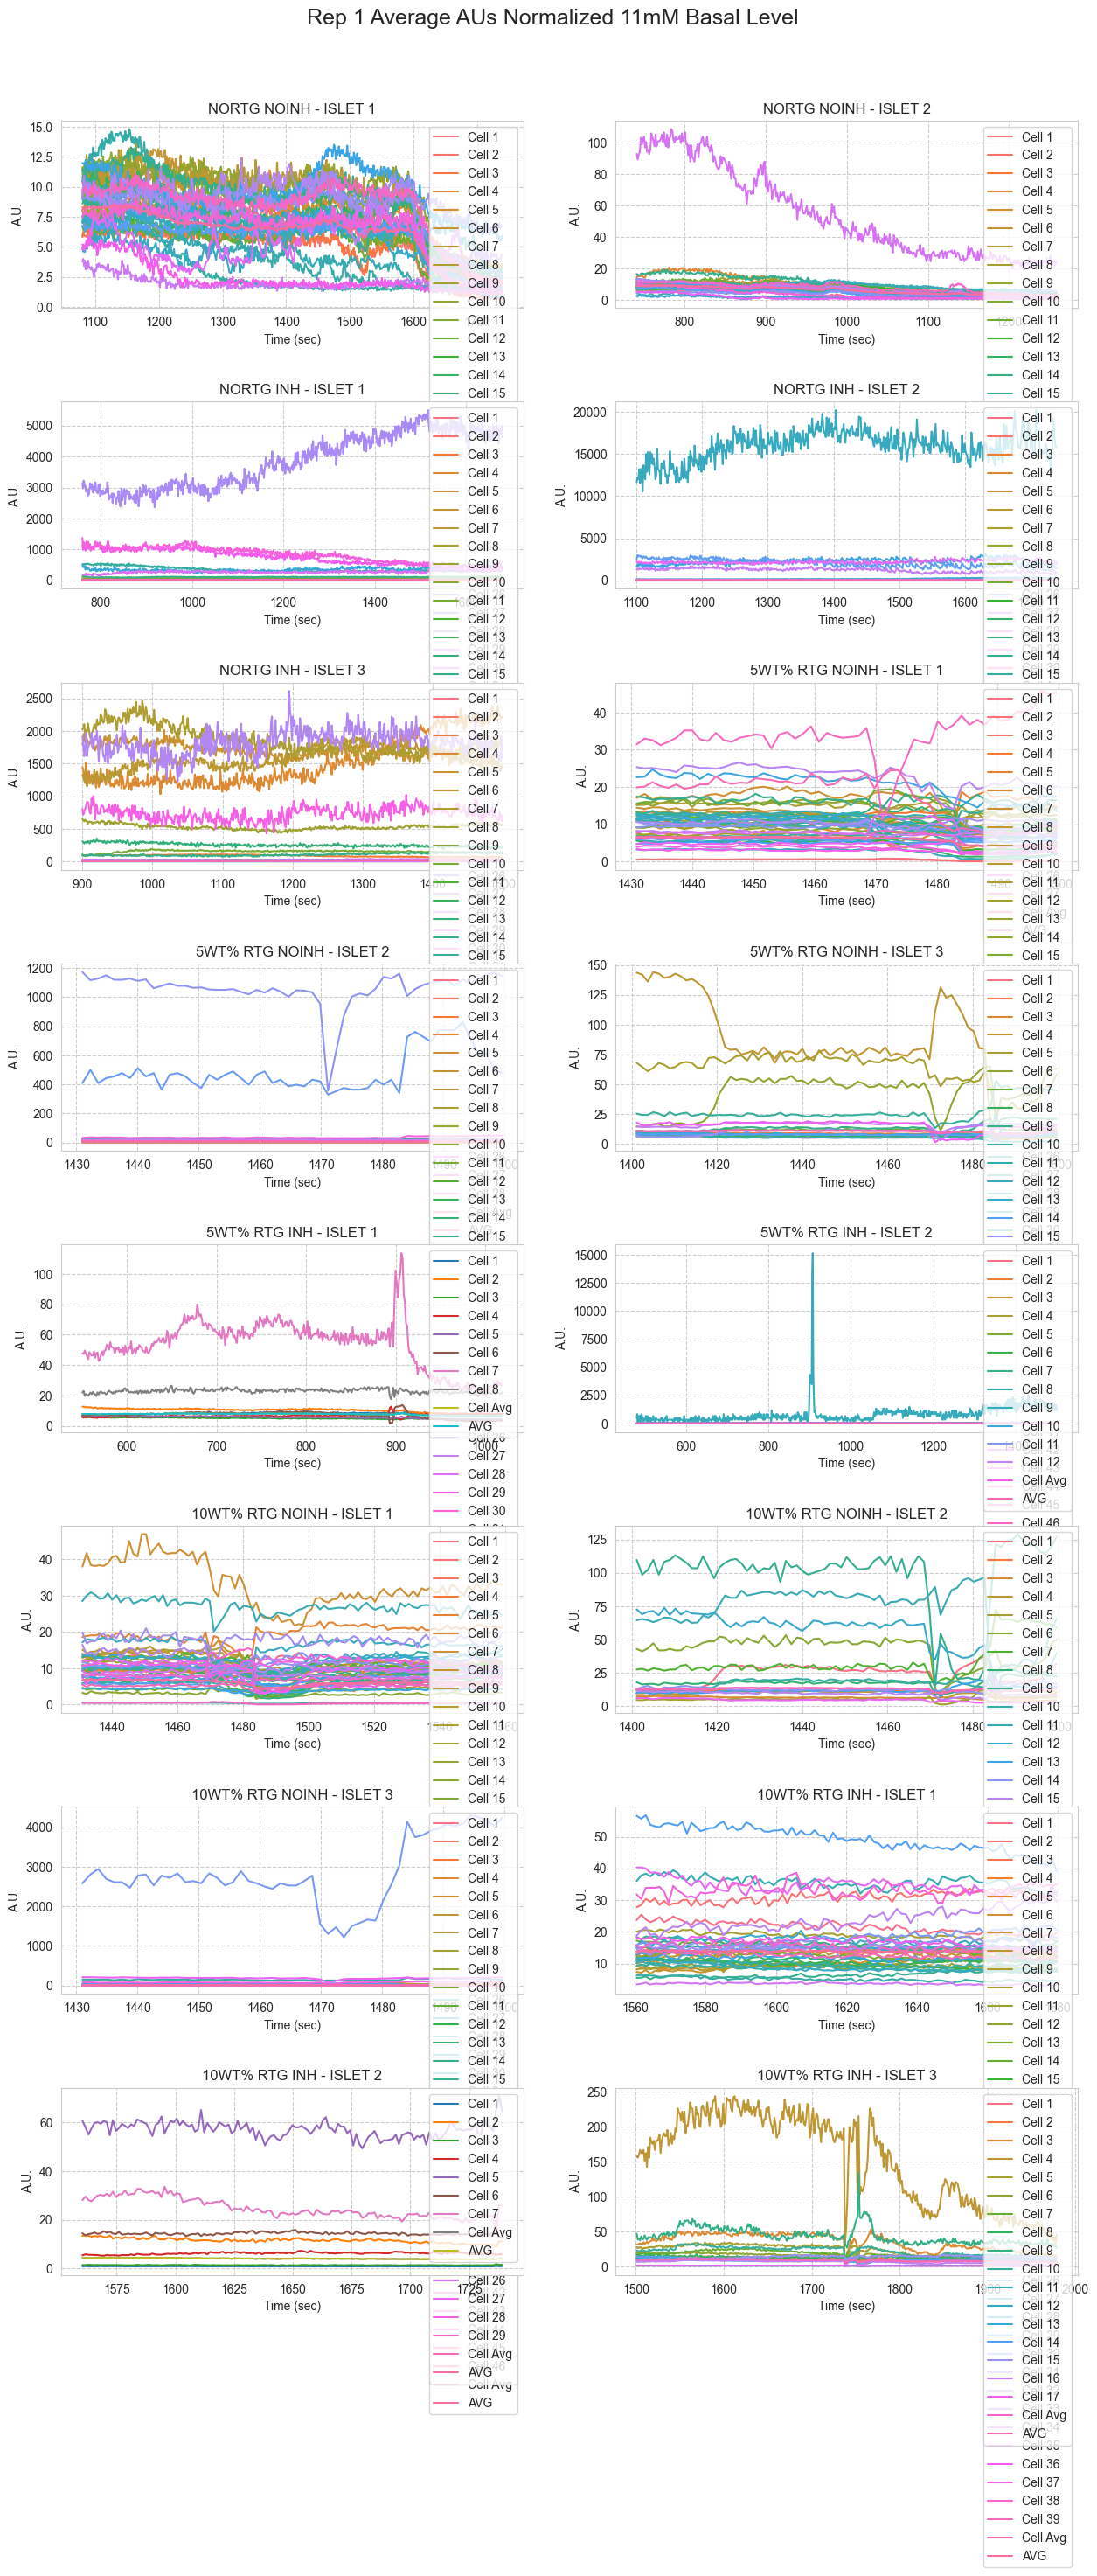

In [17]:
treatments = df.Treatment.unique()

plt.figure(figsize=(15, int(2*len(treatments))))
plt.subplots_adjust(hspace=.5)
plt.suptitle("Rep 1 Average AUs Normalized 11mM Basal Level", fontsize=18, y=0.92)

# loop through the length of tickers and keep track of index
for n, treat in enumerate(treatments):


    ax = plt.subplot(int(math.ceil(len(treatments)/2)), 2, n + 1)


    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    temp_df = temp_df[temp_df["Time (sec)"].between(temp_md["11 mM End"].iloc[0], temp_md["20 mM Stimulus"].iloc[0])]

    
    # filter df and plot ticker on the new subplot axis
    sns.lineplot(data = temp_df,x = "Time (sec)", y = "Normalized A.U.", hue = "Cell #")

    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("A.U.")


    # chart formatting
    ax.set_title(treat.upper())
    ax.legend()
    #ax.get_legend().remove()
    #ax.set_xlabel("")
plt.savefig(f"{folder}/Rep{rep}_11mM_curve_boundaries_displayed.png", bbox_inches = "tight");



    
    